# Ofset free MPC using matric C

In [83]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [84]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('./data/A_C_' + str(matrix_C) + '.npy')
B = np.load('./data/B_C_' + str(matrix_C) + '.npy')
C = np.load('./data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [85]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [86]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [87]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [88]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [89]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## Optimal control problem

Observer - Kalman filter

In [90]:
y_start = np.array([0.5, 0.5])
y_start = scaler.transform(y_start.reshape(1, -1))

y_setpoint = np.array([1.5, 0.8])
y_setpoint = scaler.transform(y_setpoint.reshape(1, -1))[0]

u_previous = np.array([0.2, 0.5])
u_previous = scalerU.transform(u_previous.reshape(1, -1))[0]

z_est_ = np.hstack((get_x(y_start).T, np.zeros((1,nd))))
P0 = np.eye(nz+nd) 

# Noise covariances
Q = np.eye(nz+nd) * 0.1  # process noise
R = np.eye(ny) * 0.5  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

C_ = np.hstack([
    C, np.eye(nd)
])

KF = helper.KF(A_,B_,C_,z_est_,P0, Q, R)



Target calculation

In [91]:
N = 20
Qy = np.eye(ny) * 5
Qz = C.T@Qy@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
d0 = cp.Parameter(ny)
d0.value = np.zeros(ny)
u_prev = cp.Parameter(nu)

y_sp = cp.Parameter(ny)
y_sp.value = y_setpoint
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N+1))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)


In [92]:
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.5 0.8]]


MPC problem formulation


In [93]:
z0.value = z_est_[0,0:nz]
u_prev.value = u_previous

In [94]:
z_est_

array([[-0.15221339,  0.32474217,  0.19213274, -0.1071784 ,  0.09922424,
         0.18232504, -0.03116683, -0.11548097, -0.04812007, -0.26598293,
         0.        ,  0.        ]])

In [95]:
# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k] + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [96]:
# sanity check and problem formulation
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[1.03933086 0.24594954]
optimal


In [97]:
import time

sim_time = 150
optimal = 0
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
y_sp.value = scaler.transform(np.array([[0.5,0.5]]))[0]

total_time_target = 0
total_time_mpc = 0

start_time_target = time.time()
target_estimation.solve(solver=cp.GUROBI)
end_time_target = time.time()
print(f"Target estimation solve time: {end_time_target - start_time_target:.4f} seconds")
total_time_target += end_time_target - start_time_target
z_ref.value = z_s.value

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]

for k in range(sim_time):
    if k == 50:
        y_sp.value = y_setpoint
    # solve MPC
    start_time_mpc = time.time()
    mpc.solve(solver=cp.GUROBI)
    end_time_mpc = time.time()
    print(f"MPC solve time at step {k}: {end_time_mpc - start_time_mpc:.4f} seconds")
    total_time_mpc += end_time_mpc - start_time_mpc
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = KF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    start_time_target = time.time()
    target_estimation.solve(solver=cp.GUROBI)
    end_time_target = time.time()
    print(f"Target estimation solve time at step {k}: {end_time_target - start_time_target:.4f} seconds")
    total_time_target += end_time_target - start_time_target
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    if mpc.status == "optimal":
        optimal += 1

print(f"Total time spent in target estimation: {total_time_target:.4f} seconds")
print(f"Total time spent in MPC solve: {total_time_mpc:.4f} seconds")

Target estimation solve time: 0.0017 seconds
MPC solve time at step 0: 0.0131 seconds
Target estimation solve time at step 0: 0.0016 seconds
user_limit
MPC solve time at step 1: 0.0120 seconds
Target estimation solve time at step 1: 0.0014 seconds
optimal
MPC solve time at step 2: 0.0114 seconds
Target estimation solve time at step 2: 0.0015 seconds
optimal
MPC solve time at step 3: 0.0121 seconds
Target estimation solve time at step 3: 0.0012 seconds
optimal
MPC solve time at step 4: 0.0114 seconds
Target estimation solve time at step 4: 0.0012 seconds
optimal
MPC solve time at step 5: 0.0116 seconds
Target estimation solve time at step 5: 0.0012 seconds
optimal
MPC solve time at step 6: 0.0129 seconds
Target estimation solve time at step 6: 0.0013 seconds
optimal
MPC solve time at step 7: 0.0108 seconds
Target estimation solve time at step 7: 0.0013 seconds
optimal
MPC solve time at step 8: 0.0109 seconds
Target estimation solve time at step 8: 0.0013 seconds
optimal
MPC solve time a

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Target estimation solve time at step 14: 0.0014 seconds
optimal
MPC solve time at step 15: 0.0105 seconds
Target estimation solve time at step 15: 0.0013 seconds
optimal
MPC solve time at step 16: 0.0122 seconds
Target estimation solve time at step 16: 0.0013 seconds
optimal
MPC solve time at step 17: 0.0087 seconds
Target estimation solve time at step 17: 0.0013 seconds
optimal
MPC solve time at step 18: 0.0101 seconds
Target estimation solve time at step 18: 0.0012 seconds
optimal
MPC solve time at step 19: 0.0123 seconds
Target estimation solve time at step 19: 0.0013 seconds
optimal
MPC solve time at step 20: 0.0094 seconds
Target estimation solve time at step 20: 0.0013 seconds
optimal
MPC solve time at step 21: 0.0118 seconds
Target estimation solve time at step 21: 0.0013 seconds
optimal
MPC solve time at step 22: 0.0091 seconds
Target estimation solve time at step 22: 0.0014 seconds
optimal
MPC solve time at step 23: 0.0096 seconds
Target estimation solve time at step 23: 0.001

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

Target estimation solve time at step 59: 0.0016 seconds
user_limit
MPC solve time at step 60: 0.0144 seconds
Target estimation solve time at step 60: 0.0012 seconds
user_limit
MPC solve time at step 61: 0.0126 seconds
Target estimation solve time at step 61: 0.0016 seconds
optimal
MPC solve time at step 62: 0.0109 seconds
Target estimation solve time at step 62: 0.0017 seconds
optimal
MPC solve time at step 63: 0.0098 seconds
Target estimation solve time at step 63: 0.0015 seconds
optimal
MPC solve time at step 64: 0.0092 seconds
Target estimation solve time at step 64: 0.0014 seconds
optimal
MPC solve time at step 65: 0.0087 seconds
Target estimation solve time at step 65: 0.0016 seconds
optimal
MPC solve time at step 66: 0.0118 seconds
Target estimation solve time at step 66: 0.0017 seconds
optimal
MPC solve time at step 67: 0.0096 seconds
Target estimation solve time at step 67: 0.0013 seconds
optimal
MPC solve time at step 68: 0.0134 seconds
Target estimation solve time at step 68:

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


MPC solve time at step 75: 0.0120 seconds
Target estimation solve time at step 75: 0.0013 seconds
optimal
MPC solve time at step 76: 0.0124 seconds
Target estimation solve time at step 76: 0.0014 seconds
optimal
MPC solve time at step 77: 0.0104 seconds
Target estimation solve time at step 77: 0.0020 seconds
optimal
MPC solve time at step 78: 0.0102 seconds
Target estimation solve time at step 78: 0.0016 seconds
optimal
MPC solve time at step 79: 0.0138 seconds
Target estimation solve time at step 79: 0.0015 seconds
optimal
MPC solve time at step 80: 0.0122 seconds
Target estimation solve time at step 80: 0.0017 seconds
optimal
MPC solve time at step 81: 0.0114 seconds
Target estimation solve time at step 81: 0.0024 seconds
optimal
MPC solve time at step 82: 0.0202 seconds
Target estimation solve time at step 82: 0.0023 seconds
user_limit
MPC solve time at step 83: 0.0302 seconds
Target estimation solve time at step 83: 0.0035 seconds
optimal
MPC solve time at step 84: 0.0233 seconds
T

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


MPC solve time at step 86: 0.0128 seconds
Target estimation solve time at step 86: 0.0019 seconds
optimal
MPC solve time at step 87: 0.0100 seconds
Target estimation solve time at step 87: 0.0022 seconds
optimal
MPC solve time at step 88: 0.0145 seconds
Target estimation solve time at step 88: 0.0014 seconds
optimal
MPC solve time at step 89: 0.0108 seconds
Target estimation solve time at step 89: 0.0017 seconds
optimal
MPC solve time at step 90: 0.0166 seconds
Target estimation solve time at step 90: 0.0039 seconds
optimal
MPC solve time at step 91: 0.0190 seconds
Target estimation solve time at step 91: 0.0022 seconds
optimal
MPC solve time at step 92: 0.0185 seconds
Target estimation solve time at step 92: 0.0041 seconds
user_limit
MPC solve time at step 93: 0.0197 seconds
Target estimation solve time at step 93: 0.0030 seconds
user_limit
MPC solve time at step 94: 0.0114 seconds
Target estimation solve time at step 94: 0.0017 seconds
optimal
MPC solve time at step 95: 0.0116 second

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


MPC solve time at step 110: 0.0132 seconds
Target estimation solve time at step 110: 0.0016 seconds
optimal
MPC solve time at step 111: 0.0110 seconds
Target estimation solve time at step 111: 0.0015 seconds
optimal
MPC solve time at step 112: 0.0101 seconds
Target estimation solve time at step 112: 0.0019 seconds
optimal
MPC solve time at step 113: 0.0142 seconds
Target estimation solve time at step 113: 0.0015 seconds
optimal
MPC solve time at step 114: 0.0157 seconds
Target estimation solve time at step 114: 0.0017 seconds
optimal
MPC solve time at step 115: 0.0132 seconds
Target estimation solve time at step 115: 0.0019 seconds
optimal
MPC solve time at step 116: 0.0132 seconds
Target estimation solve time at step 116: 0.0014 seconds
user_limit
MPC solve time at step 117: 0.0109 seconds
Target estimation solve time at step 117: 0.0013 seconds
optimal
MPC solve time at step 118: 0.0119 seconds
Target estimation solve time at step 118: 0.0015 seconds
optimal
MPC solve time at step 11

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Target estimation solve time at step 125: 0.0018 seconds
optimal
MPC solve time at step 126: 0.0253 seconds
Target estimation solve time at step 126: 0.0026 seconds
user_limit
MPC solve time at step 127: 0.0156 seconds
Target estimation solve time at step 127: 0.0017 seconds
optimal
MPC solve time at step 128: 0.0134 seconds
Target estimation solve time at step 128: 0.0014 seconds
optimal
MPC solve time at step 129: 0.0137 seconds
Target estimation solve time at step 129: 0.0016 seconds
user_limit
MPC solve time at step 130: 0.0130 seconds
Target estimation solve time at step 130: 0.0016 seconds
optimal
MPC solve time at step 131: 0.0118 seconds
Target estimation solve time at step 131: 0.0018 seconds
optimal
MPC solve time at step 132: 0.0139 seconds
Target estimation solve time at step 132: 0.0014 seconds
optimal
MPC solve time at step 133: 0.0132 seconds
Target estimation solve time at step 133: 0.0017 seconds
user_limit
MPC solve time at step 134: 0.0423 seconds
Target estimation s

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Target estimation solve time at step 135: 0.0022 seconds
optimal
MPC solve time at step 136: 0.0160 seconds
Target estimation solve time at step 136: 0.0014 seconds
optimal
MPC solve time at step 137: 0.0201 seconds
Target estimation solve time at step 137: 0.0016 seconds
optimal
MPC solve time at step 138: 0.0126 seconds
Target estimation solve time at step 138: 0.0015 seconds
optimal
MPC solve time at step 139: 0.0124 seconds
Target estimation solve time at step 139: 0.0014 seconds
optimal
MPC solve time at step 140: 0.0110 seconds
Target estimation solve time at step 140: 0.0018 seconds
optimal
MPC solve time at step 141: 0.0199 seconds
Target estimation solve time at step 141: 0.0031 seconds
optimal
MPC solve time at step 142: 0.0144 seconds
Target estimation solve time at step 142: 0.0015 seconds
optimal
MPC solve time at step 143: 0.0134 seconds
Target estimation solve time at step 143: 0.0018 seconds
optimal
MPC solve time at step 144: 0.0119 seconds
Target estimation solve time

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [98]:
optimal

130

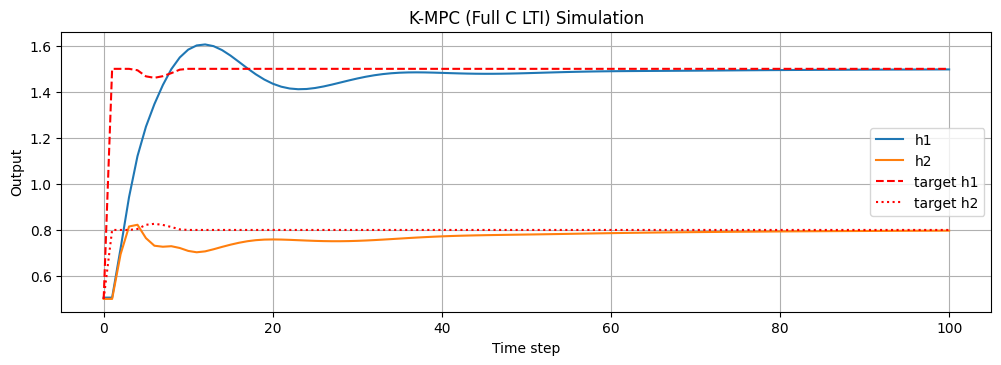

In [99]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0,50:], label='h1')
plt.plot(y_sim_descaled[1,50:], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0,50:], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1,50:], color='red', linestyle=':', label='target h2')
plt.xlabel('Time step')
plt.title('K-MPC (Full C LTI) Simulation')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [100]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 116


In [101]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 128


In [102]:
from sklearn.metrics import mean_squared_error

# Descales ys_sim
ys_sim_descaled = scaler.inverse_transform(ys_sim.T).T

# Compute MSE for each output
mse_h1 = mean_squared_error(ys_sim_descaled[0], y_sim_descaled[0])
mse_h2 = mean_squared_error(ys_sim_descaled[1], y_sim_descaled[1])

print(f"MSE for h1: {mse_h1}")
print(f"MSE for h2: {mse_h2}")

MSE for h1: 0.014818375438726928
MSE for h2: 0.0016541966889351842


In [103]:
from numpy import trapz

# Compute ISE for each output
ise_h1 = trapz((ys_sim_descaled[0] - y_sim_descaled[0])**2)
ise_h2 = trapz((ys_sim_descaled[1] - y_sim_descaled[1])**2)

print(f"ISE for h1: {ise_h1}")
print(f"ISE for h2: {ise_h2}")

ISE for h1: 2.237571545419909
ISE for h2: 0.24977896772087968


In [104]:
from numpy import trapz

# Compute ISE for y_sim starting from step 50
ise_h1 = trapz((y_sim[0, 50:] - y_setpoint[0])**2)
ise_h2 = trapz((y_sim[1, 50:] - y_setpoint[1])**2)

print(f"ISE for h1 (from step 50): {ise_h1}")
print(f"ISE for h2 (from step 50): {ise_h2}")


ISE for h1 (from step 50): 3.520538937765274
ISE for h2 (from step 50): 0.5251616653842373


In [105]:
y_sim[:, k] - y_setpoint

array([-0.0029429 , -0.00446508])

In [113]:
# Compute the closed-loop value of the objective function

objective_value = 0
for k in range(50,sim_time):
    y_diff = y_sim[:, k] - y_setpoint
    u_diff = u_sim[:, k]-u_sim[:, k-1]
    objective_value += y_diff.T @ Qy @ y_diff 
    #objective_value += u_diff.T @ Qu @ u_diff

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 23.816718953662217


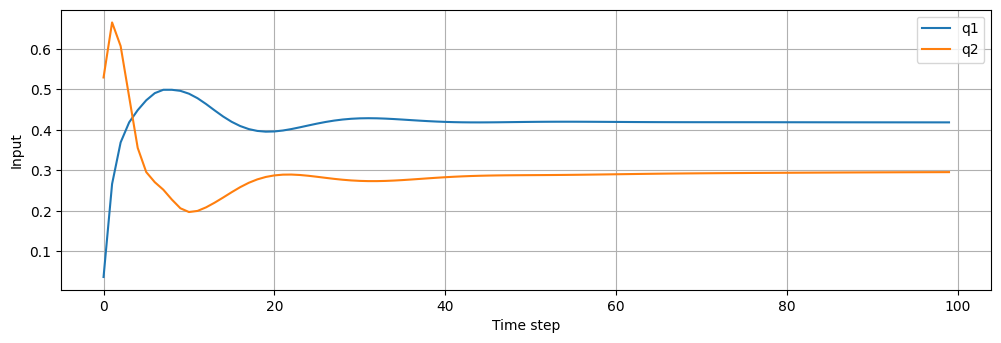

In [107]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0,50:], label='q1')
plt.plot(u_sim_descaled[1,50:], label='q2')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.legend()
plt.grid(True) 

In [108]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[44.8355502  54.35015506]


/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_12487/621697738.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


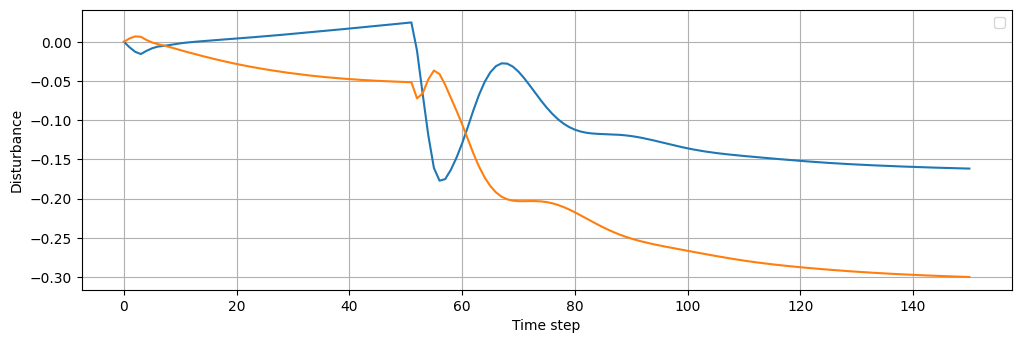

In [109]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_12487/4249820153.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


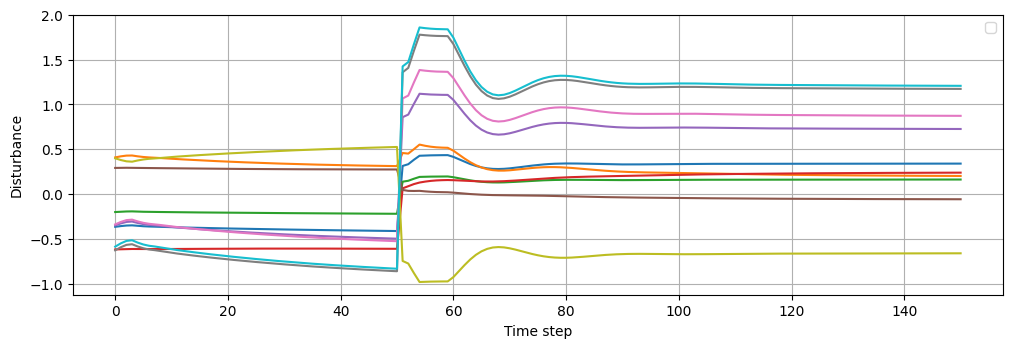

In [110]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_12487/2974051967.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


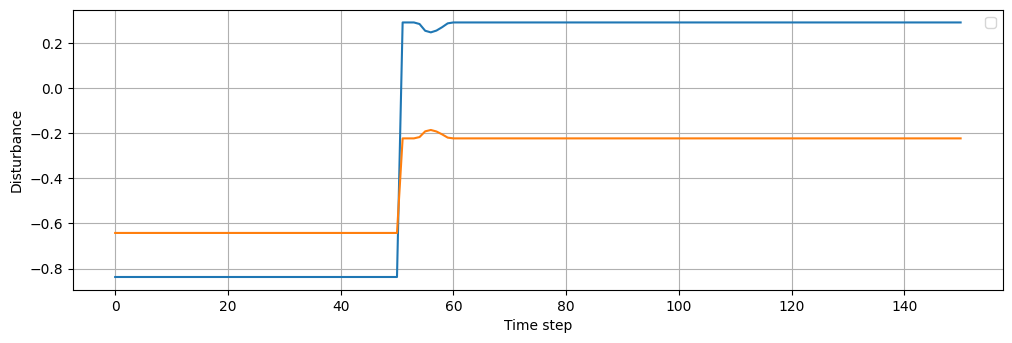

In [111]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)